# How does our detection efficiency in astrometric binaries change with increasing distance?

In [4]:
import sys
sys.path.insert(0, "../code")

import h5py as h5
import itertools
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy import (coordinates as coord, units as u)
from astropy.coordinates.matrix_utilities import (matrix_product, rotation_matrix)
from tqdm import tqdm
from scipy import (optimize as op)
from astropy import constants

from matplotlib.colors import LogNorm
from matplotlib import cm
from mpl_utils import mpl_style
from matplotlib.collections import LineCollection

import twobody


plt.style.use(mpl_style)

%matplotlib inline


np.random.seed(0)

In [39]:
def approximate_ruwe(t, P, m1, m2, distance, f1=None, f2=None, t0=None, 
                     i=0*u.deg, **kwargs):
    """
    Approximate the on-sky astrometric excess noise for a binary system with the
    given system parameters at a certain distance.

    This approximating function ignores the following effects:

    (1) The distortions that arise due to sky projections.
    (2) Inclination effects.
    (3) Omega effects.

    In part it also assumes:

    (1) The times were observed pseudo-randomly.
    (2) The orbit is fully sampled.

    :param t:
        The times that the system was observed.

    :param P:
        The period of the binary system.

    :param m1:
        The mass of the primary star.

    :param m2:
        The mass of the secondary system.

    :param distance:
        The distance from the observer to the center of mass of the binary
        system.

    :param f1: [optional]
        The flux of the primary star. If `None` is given then this is assumed to
        be $m_1^{3.5}$.

    :param f2: [optional]
        The flux of the secondary. If `None` is given then this is assumed to be
        $m_2^{3.5}$.

    :returns:
        A two-part tuple containing the root-mean-squared deviations in on-sky
        position (in units of milliarcseconds), and a dictionary containing meta
        information about the binary system.
    """

    if f1 is None:
        f1 = m1.to(u.solMass).value**3.5
    if f2 is None:
        f2 = m2.to(u.solMass).value**3.5

    if t0 is None:
        t0 = Time('J2015.5')

    m_total = m1 + m2
    w = np.array([f1, f2])/(f1 + f2)
    a = twobody.P_m_to_a(P, m_total).to(u.AU).value

    a1 = m2 * a / m_total
    a2 = m1 * a / m_total

    w1, w2 = (w[0], w[1])

    # TODO: replace this with integral!
    dt = (t - t0).to(u.day)
    phi = (2 * np.pi * dt / P).value
    N = phi.size

    dx = a1 * w1 * np.cos(phi) + a2 * w2 * np.cos(phi + np.pi)
    dy = a1 * w1 * np.sin(phi) + a2 * w2 * np.sin(phi + np.pi)

    planar_rms_in_au = np.sqrt(np.sum((dx - np.mean(dx))**2 + (dy - np.mean(dy))**2)/N).value

    # Need some corrections for when the period is longer than the observing timespan, and the
    # inclination angle is non-zero.

    # For this it really depends on what t0/Omega is: if you see half the orbit in one phase or
    # another...
    # TODO: this requires a thinko.
    

    """
    Approximate given some inclination angle.
    At zero inclination, assume circle on sky such that:
    
        rms = sqrt(ds^2 + ds^2) = sqrt(2ds^2)

    and 
        
        ds = np.sqrt(0.5 * rms^2)

    Now when inclined (even at 90) we still get ds + contribution:

        rms_new = sqrt(ds^2 + (cos(i) * ds)^2)
    """

    ds = np.sqrt(0.5 * planar_rms_in_au**2)
    rms_in_au = np.sqrt(ds**2 + (np.cos(i) * ds)**2)
    rms_in_mas = (rms_in_au * u.au / distance).to(u.mas, equivalencies=u.dimensionless_angles())

    # Intrinsic error on position in one direction is.
    # These are the final values. The individual epochs are probably about a 10th of this.
    intrinsic_ra_error = 0.029 # mas
    intrinsic_dec_error = 0.026 # mas

    intrinsic_ra_error /= 10
    intrinsic_dec_error /= 10

    chi2 = N * rms_in_mas.to(u.mas).value**2 / np.sqrt(intrinsic_ra_error**2 + intrinsic_dec_error**2)

    approx_ruwe = np.sqrt(chi2/(N - 2))

    meta = dict(weights=w,
                a=a,
                a1=a1,
                a2=a2,
                w1=w1,
                w2=w2,
                phi=phi,
                dx=dx,
                dy=dy,
                rms_in_au=rms_in_au)

    return (approx_ruwe, meta)

Let us assume the following:
- a log-normal distribution in periods
- a uniform distribution in mass ratios
- the primary star mass is drawn from a Salpeter IMF
- the per-transit astrometric error in position is constant up to G < 12
- assume inclination angles are uniform in cos(i)

We will assume for now that the eccentricities are zero because we haven't yet tested how our approximating function works for non-zero eccentriciies.

Now let us consider main-sequence binaries (where L ~ M^3.5). At every distance $d$ we will simulate 10,000 binary systems and ask how many we would recover in astrometry.


In [40]:
def salpeter_imf(N, alpha, M_min, M_max):
    log_M_limits = np.log([M_min, M_max])

    max_ll = M_min**(1.0 - alpha)

    M = []
    while len(M) < N:
        Mi = np.exp(np.random.uniform(*log_M_limits))

        ln = Mi**(1 - alpha)
        if np.random.uniform(0, max_ll) < ln:
            M.append(Mi)

    return np.array(M)

In [61]:
np.random.seed(0)

N = 10000 # simulations per distance trial
O = 200 # number of observations per source

# Note that we are using the same Ps, qs, etc at each distance trial
P = np.random.lognormal(5.03, 2.28, N) * u.day # Raghavan et al. (2010)
q = np.random.uniform(0.1, 1, N)
cos_i = np.random.uniform(0, 1, N)
i = np.arccos(cos_i) * u.rad

M_1 = salpeter_imf(N, 2.35, 0.1, 100) * u.solMass
M_2 = q * M_1

# Assume main-sequence systems.
f_1 = M_1.value**3.5
f_2 = M_2.value**3.5


# Assume that we observe each system at a uniformly random time.
# From https://www.cosmos.esa.int/web/gaia/dr2
obs_start, obs_end = (Time('2014-07-25T10:30'), Time('2016-05-23T11:35')) 
t = obs_start + np.random.uniform(0, 1, O) * (obs_end - obs_start)

# Let us assume that anything with RUWE > 1.5 will be a binary.
ruwe_binarity_threshold = 1.5

In [67]:
fiducial_distance = 1 * u.pc
fiducial_ruwe = np.zeros(N, dtype=float)
for j in tqdm(range(N)):
    fiducial_ruwe[j], meta = approximate_ruwe(t, P[j], M_1[j], M_2[j], fiducial_distance, f1=f_1[j], f2=f_2[j], i=i[j])


100%|██████████| 10000/10000 [00:29<00:00, 336.92it/s]


In [68]:
# Now calculate for many distances.
distances = np.linspace(1, 10000, 10000) * u.pc
D = distances.size

# Just store a detection completeness at each distance.
completeness = np.zeros(D, dtype=float)
for j, distance in tqdm(enumerate(distances)):
    ruwe = fiducial_ruwe * (fiducial_distance/distance)
    # Calculate the efficiency of detection at this distance
    completeness[j] = np.sum(ruwe >= ruwe_binarity_threshold)/N
    

10000it [00:02, 4990.96it/s]


[]

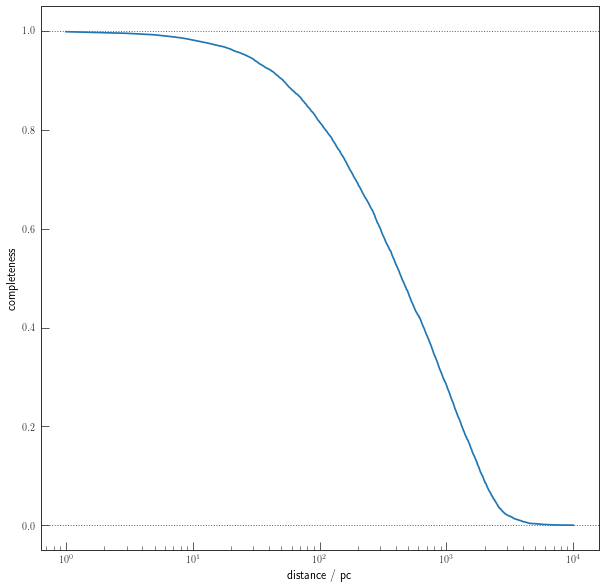

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(distances, completeness, ms=0)
ax.axhline(0, c="#666666", linestyle=":", lw=1, zorder=-1, ms=0)
ax.axhline(1, c="#666666", linestyle=":", lw=1, zorder=-1, ms=0)
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"{distance / pc}")
ax.set_ylabel(r"{completeness}")
ax.semilogx()

In [70]:
# Enhance

[]

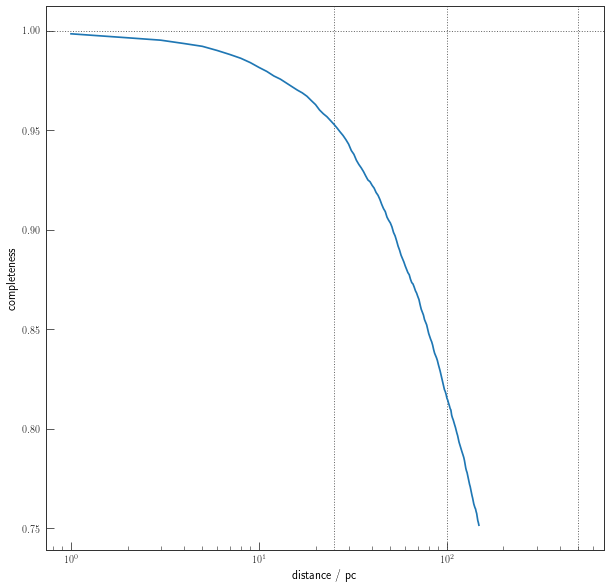

In [71]:
mask = completeness > 0.75

axline_kwds = dict(c="#666666", linestyle=":", lw=1, zorder=-1, ms=0)

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(distances[mask], completeness[mask], ms=0)
ax.axhline(1, **axline_kwds)
ax.set_xlabel(r"{distance / pc}")
ax.set_ylabel(r"{completeness}")
ax.axvline(25, **axline_kwds)
ax.axvline(100, **axline_kwds)
ax.axvline(500, **axline_kwds)

ax.semilogx()

In [55]:
completeness[distances.searchsorted([25, 100, 500] * u.pc)]


array([ 0.9856,  0.903 ,  0.6092])